In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_ori = pd.read_csv('SBIN.csv')
df_ori.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,SBIN,EQ,225.60,236.00,243.65,234.25,243.65,243.65,240.83,2373228,5.715338e+13,NaN,NaN,NaN
1,2000-01-04,SBIN,EQ,243.65,243.65,262.00,238.85,258.00,259.10,251.46,4495741,1.130506e+14,NaN,NaN,NaN
2,2000-01-05,SBIN,EQ,259.10,249.00,264.70,245.00,249.05,248.45,252.35,3434058,8.666008e+13,NaN,NaN,NaN
3,2000-01-06,SBIN,EQ,248.45,252.00,268.00,252.00,260.50,261.00,262.18,6658801,1.745817e+14,NaN,NaN,NaN
4,2000-01-07,SBIN,EQ,261.00,261.50,279.90,255.00,279.00,273.30,269.02,7873985,2.118287e+14,NaN,NaN,NaN


Let us look for NAN values if any in 'VWAP' and 'Date' (as our model depends on these values most)

In [60]:
df_ori['VWAP'].isnull().value_counts()# No NAN values

False    5059
Name: VWAP, dtype: int64

In [61]:
df_ori['Date'].isnull().value_counts()

False    5059
Name: Date, dtype: int64

Our data does not require Data Cleaning , So let's proceed .

In [4]:
df_new = df_ori[['VWAP']]

In [6]:
df_new.index = df_ori['Date']

Training our model on the first 4000 values and rest for testing/

In [7]:
df_new = df_new[:4000]
df_new.shape

(4000, 1)

In [9]:
df_new.head()

,VWAP
Date,
2000-01-03,240.83
2000-01-04,251.46
2000-01-05,252.35
2000-01-06,262.18
2000-01-07,269.02


In [10]:
df_ = df_ori[:4000]
df_ = df_[['VWAP','Date']]
df_.head()

,VWAP,Date
0,240.83,2000-01-03
1,251.46,2000-01-04
2,252.35,2000-01-05
3,262.18,2000-01-06
4,269.02,2000-01-07


Let us train our data on the first 4000 values

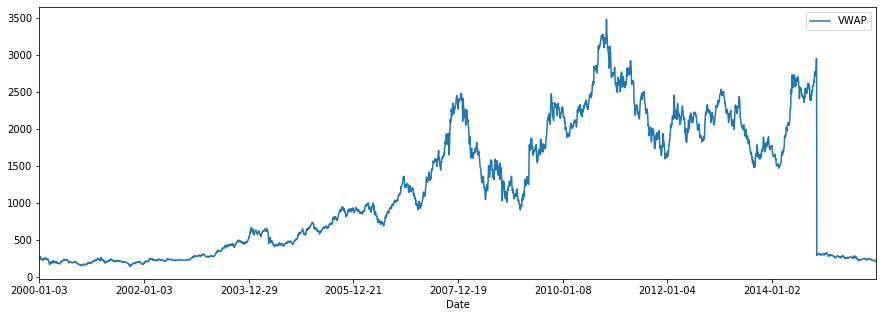

In [12]:
df_.plot(kind='line',x='Date',y='VWAP',figsize=(15,5))

In order to make predection , we will perform FFT on the change in stock price

In [13]:
df_['delta']= np.append(np.array([0]),np.diff(df_['VWAP'].values))
df_['delta'].head()    

0     0.00
1    10.63
2     0.89
3     9.83
4     6.84
Name: delta, dtype: float64

Using FFT , we have calculated our superposition values.

In [14]:
sp = np.fft.fft(df_['delta'].values)

In [15]:
sp[:10]

array([  -41.79         +0.j        , -3111.22055472-1424.57366909j,
        -656.90527994-1514.07247263j,  -245.801606   -936.6905781j ,
       -1546.26947709-1214.9510695j ,  2267.58082632-3396.30933588j,
         838.85897789+1482.5931978j ,   176.25438619-3406.75680257j,
        2629.27735267 +716.23067215j,  4091.15482981 -142.99352945j])

In [16]:
df_['theta']= np.arctan(sp.imag/sp.real) #theta = tan^-1(img/real)
numValues = len(df_)
numValuesHalf= numValues/2
df_['amplitude']= np.sqrt(sp.real**2  +sp.imag**2)/numValuesHalf
df_['Freq']= np.fft.fftfreq(sp.size,d=1) # dividing 4000 values amoung all.
df_.head()

,VWAP,Date,delta,theta,amplitude,Freq
0,240.83,2000-01-03,0.00,-0.000000,0.020895,0.00000
1,251.46,2000-01-04,10.63,0.429390,1.710928,0.00025
2,252.35,2000-01-05,0.89,1.161440,0.825218,0.00050
3,262.18,2000-01-06,9.83,1.314168,0.484202,0.00075
4,269.02,2000-01-07,6.84,0.665979,0.983242,0.00100


The frequency and amplitude values can be used to determine the dominant frequency. As we know for ny Fourier Transform function, we will have a mirror image along the middle.
It forms a mirror image as the frequency values we get are both positive and negative , So, for the positive values we get corresponding negative values also.

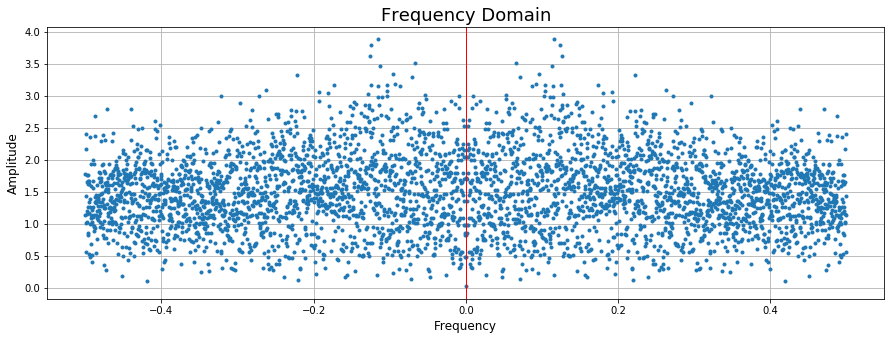

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df_['Freq'],df_['amplitude'].values, '.')
plt.axvline(x=0, ymin=0, ymax=1 , linewidth=1, color='r')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.title('Frequency Domain', fontsize=18)
plt.grid()

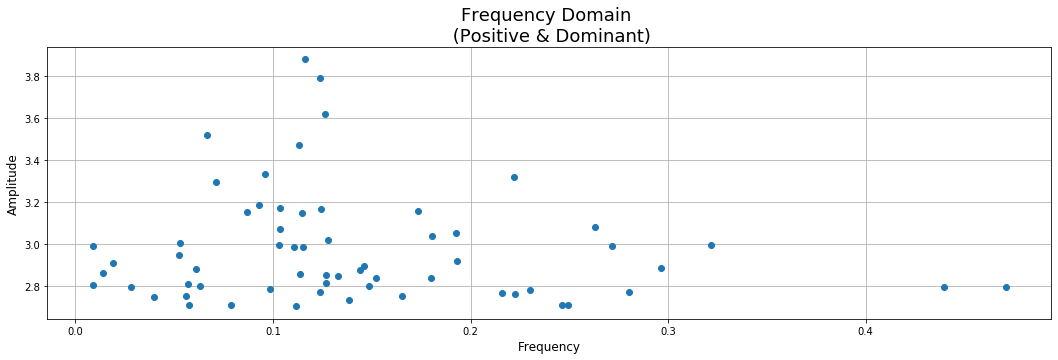

In [18]:
meanAmp = df_['amplitude'].mean()
stdAmp= df_['amplitude'].std()
dominantAmpCheck = df_['amplitude']> (2*stdAmp + meanAmp)
positiveFreqCheck = df_['Freq'] > 0
dominantAmp = df_[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df_[dominantAmpCheck & positiveFreqCheck]['Freq']
dominantTheta = df_[dominantAmpCheck & positiveFreqCheck]['theta']

plt.figure(figsize=(18,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude',fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.title('Frequency Domain \n (Positive & Dominant)',fontsize=18)
plt.grid()

From the above dominant frequency values,  we can attempt to reconstruct the stock prices. Since we have been using time delta , we will perform cumsum on all the time deltas and add it to the initial closing stock value to perform regression.

In [30]:
regressionDelta = 0

for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df_))) + shift)


#Converting Delta Time to Time at start value of real data    
startValue = df_['VWAP'][0]
regression = startValue + np.cumsum(regressionDelta)

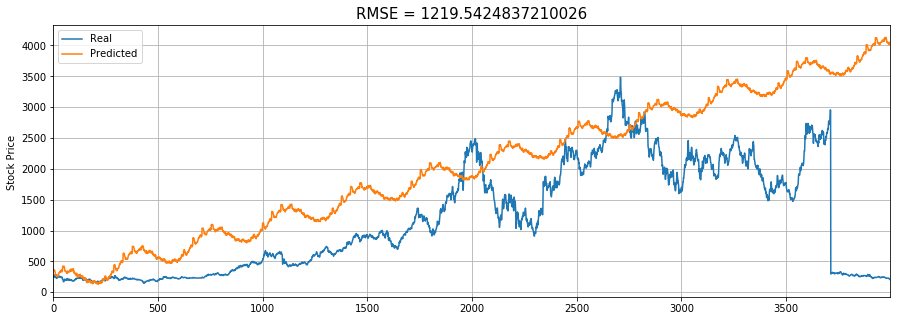

In [32]:
plt.figure(figsize=(15,5))
df_['VWAP'].plot(grid=True)
plt.plot(regression)
plt.ylabel('Stock Price ')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((df_['VWAP'].values - regression)**2))# root mean square error

plt.title('RMSE = ' + str(rmse), fontsize=15);

Now as our preliminary results are'nt that bad , So , let us try to optimize our filter value (the standard deviation) to minimize our RSME

In [44]:
def std_filter(std_value):
    
    #Getting dominant values based on std_value
    meanAmp = df_['amplitude'].mean()
    stdAmp = df_['amplitude'].std()
    dominantAmpCheck = df_['amplitude'] > (std_value*stdAmp + meanAmp) 
    positiveFreqCheck = df_['Freq'] > 0
    dominantAmp = df_[dominantAmpCheck & positiveFreqCheck]['amplitude']
    dominantFreq = df_[dominantAmpCheck & positiveFreqCheck]['Freq']
    dominantTheta = df_[dominantAmpCheck & positiveFreqCheck]['theta']
    dominantTheta.reset_index(drop=True, inplace=True)
    dominantAmp.reset_index(drop=True, inplace=True)
    #Calculating Regression Delta
    regressionDelta = 0
    for n in range(len(dominantTheta)):
        shift = dominantTheta[n]
        regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df_))) + shift)

    #Converting Delta Time to Time at start value of real data    
    startValue = df_['VWAP'][0]
    regression = startValue - np.cumsum(regressionDelta)
    
    #Calculating RMSE
    rmse = np.sqrt(np.mean((df_['VWAP'].values - regression)**2))
    
    if np.isnan(rmse):
        rmse = 10000000000000
    
    return rmse

In [45]:
std_values = []
rmse_values = []

for i in np.linspace(0,2,20):
    std_values.append(i)
    rmse_values.append(std_filter(i))

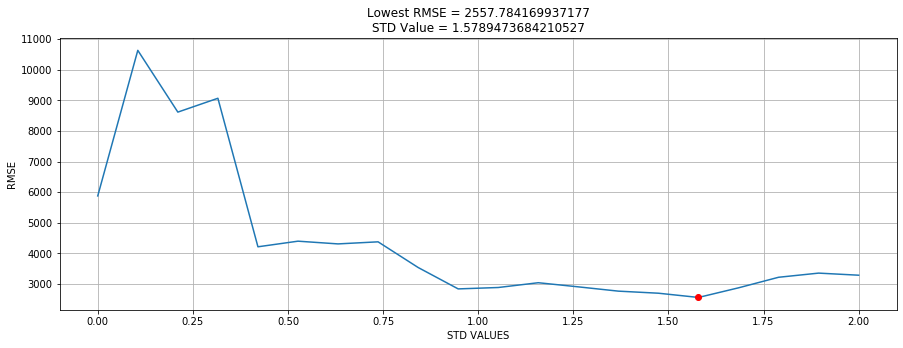

In [46]:
idx = np.array(rmse_values).argmin()
minSTD = std_values[idx]
minRMSE = rmse_values[idx]

plt.figure(figsize=(15,5))
plt.plot(std_values, rmse_values)
plt.plot(minSTD, minRMSE, 'ro')
plt.ylabel('RMSE')
plt.xlabel('STD VALUES')
plt.title('Lowest RMSE = '+str(minRMSE)+'\nSTD Value = '+str(minSTD))
plt.grid()

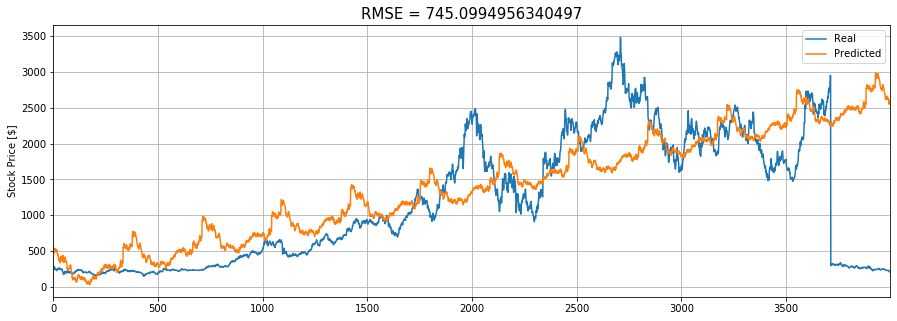

In [50]:
meanAmp = df_['amplitude'].mean()
stdAmp = df_['amplitude'].std()
dominantAmpCheck = df_['amplitude'] > (minSTD*stdAmp + meanAmp) 
positiveFreqCheck = df_['Freq'] > 0
dominantAmp = df_[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df_[dominantAmpCheck & positiveFreqCheck]['Freq']
dominantTheta = df_[dominantAmpCheck & positiveFreqCheck]['theta']
dominantTheta.reset_index(drop=True, inplace=True)
dominantAmp.reset_index(drop=True, inplace=True)
#Calculating Regression Delta
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df_))) + shift)

#Converting Delta Time to Time at start value of real data    
startValue = df_['VWAP'][0]
regression = startValue + np.cumsum(regressionDelta)

plt.figure(figsize=(15,5))
df_['VWAP'].plot(grid=True)
plt.plot(regression)
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((df_['VWAP'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

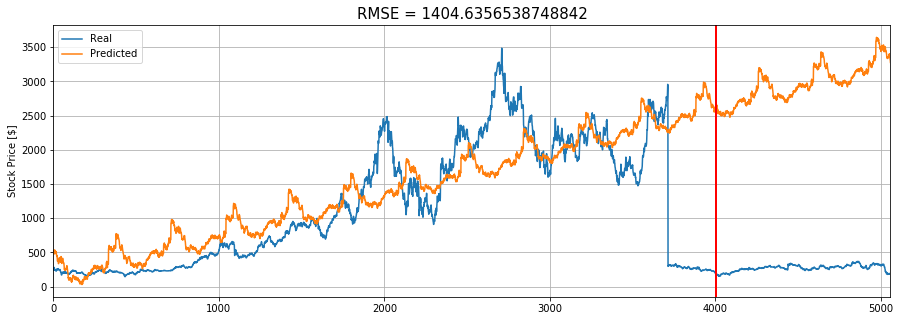

In [51]:
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df_ori))) + shift)

#Converting Delta Time to Time at start value of real data    
startValue = df_['VWAP'][0]
regression = startValue + np.cumsum(regressionDelta)

plt.figure(figsize=(15,5))
df_ori['VWAP'].plot(grid=True)
plt.plot(regression)
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted'])

plt.axvline(x=4001, ymin=0, ymax = 1, linewidth=2, color='r')

rmse = np.sqrt(np.mean((df_ori['VWAP'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);  # volume weighted average price

In [52]:
df_ori.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
5054,2020-04-24,SBIN,EQ,186.70,184.0,184.00,179.0,180.15,179.75,181.25,65146846,1.180784e+15,416448.0,21469774.0,0.3296
5055,2020-04-27,SBIN,EQ,179.75,183.5,183.50,180.5,181.00,180.90,181.89,43003001,7.821622e+14,228810.0,11778938.0,0.2739
5056,2020-04-28,SBIN,EQ,180.90,182.0,185.35,181.2,184.50,184.30,183.38,49590249,9.093810e+14,224161.0,16604968.0,0.3348
5057,2020-04-29,SBIN,EQ,184.30,185.0,191.80,183.5,189.55,190.10,187.61,57470639,1.078220e+15,310886.0,19558253.0,0.3403
5058,2020-04-30,SBIN,EQ,190.10,193.5,195.90,189.7,190.20,190.50,193.16,63069460,1.218265e+15,366664.0,16861785.0,0.2674


As it can be observed that according to the above graph we can say that SBI stocks has seen a major drop in the year 2020 and as our data is till the last day of the month of April 2020 during which lockdown was going on , So at that time also the stock has seen a major drop .
The difference between the predicted value and curret value might not differ that much if it was'nt for COVID-19.
Lets now also analyze SBIN stocks decline in all the four lockdowns and how much every lockdown affected it's shares.

In [54]:
import os

In [55]:
dfs = []
for dirname, _, filenames in os.walk('C:/Users/Bhuvan Purohit/Documents/Python Scripts/New folder/'):
    for filename in filenames:
        dfs.append(pd.read_csv(os.path.join(dirname, filename)))

df_all=pd.concat(dfs, axis=0)
df_all["date_1"]=pd.to_datetime(df_all["<date>"], format='%Y%m%d', errors='ignore')
print("Total records: ", len(df_all))

Total records:  82109


In [56]:
df_all.head()

,<ticker>,<date>,<open>,<high>,<low>,<close>,<volume>,<o/i>,date_1
0,20MICRONS,20200302,31.6,32.6,30.15,31.15,30895,NaN,2020-03-02
1,21STCENMGM,20200302,12.1,12.5,12.1,12.10,35334,NaN,2020-03-02
2,3IINFOTECH,20200302,2,2.05,1.9,1.90,1659814,NaN,2020-03-02
3,3MINDIA,20200302,20805,20995,20000,20131.65,3958,NaN,2020-03-02
4,3PLAND,20200302,4.75,4.75,4.35,4.50,156,NaN,2020-03-02


The data contain the information of all the Indian Stocks but in our case we will only consider the stock of SBIN

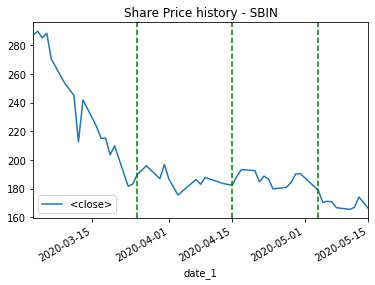

In [57]:
def plot_share_history(dfplot, tickername, draw_lockdown_lines=["2020-03-25", "2020-04-15","2020-05-04","2020-05-18"]):
    dfplot=df_all[["date_1","<close>"]][df_all["<ticker>"] == tickername]
    dfplot=dfplot.set_index("date_1")
    ax=dfplot.plot(title="Share Price history - {}".format(tickername))
    if draw_lockdown_lines is not None:
        for lock_date in draw_lockdown_lines:
            ax.axvline(lock_date, color="green", linestyle="--")

plot_share_history(df_all, "SBIN")

We can conclude that due to this pandemic the Bank sector of our nation has suffered a major loss in shares values , the reasons might be lesser account opening, no new loan sanction of any kind and lesser demand nowadays in the market.
From the above graph it can be seen that how during first lockdown shares dropped a big margin and is still declining as the lockdown is increasing in the Nation.